# Fit a Gaussian profile to lines with MCMC

In the last notebook we explored the data through quantifying **line strengths** by eye.  In this notebook we will use a probabilistic computational technique called [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to fit a Gaussian to spectral lines in HPF data.  The area under the curve of the Gaussian will then represent the line line strength.

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [2]:
goldilocks_files = glob.glob('../data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True)

In [3]:
def get_goldilocks_dataframe(fn):
    """Return a pandas Dataframe given a Goldilocks FITS file name"""
    hdus = fits.open(fn)
    df_original = pd.DataFrame()
    for j in range(28):
        df = pd.DataFrame()
        for i in range(1, 10):
            name = hdus[i].name
            df[name] = hdus[i].data[j, :]
        df['order'] = j
        df_original = df_original.append(df, ignore_index=True)
    keep_mask = df_original[df_original.columns[0:6]] != 0.0
    df_original = df_original[keep_mask.all(axis=1)].reset_index(drop=True)
    
    return df_original

In [4]:
index = 129 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [5]:
%time df = get_goldilocks_dataframe(fn)

Wall time: 699 ms


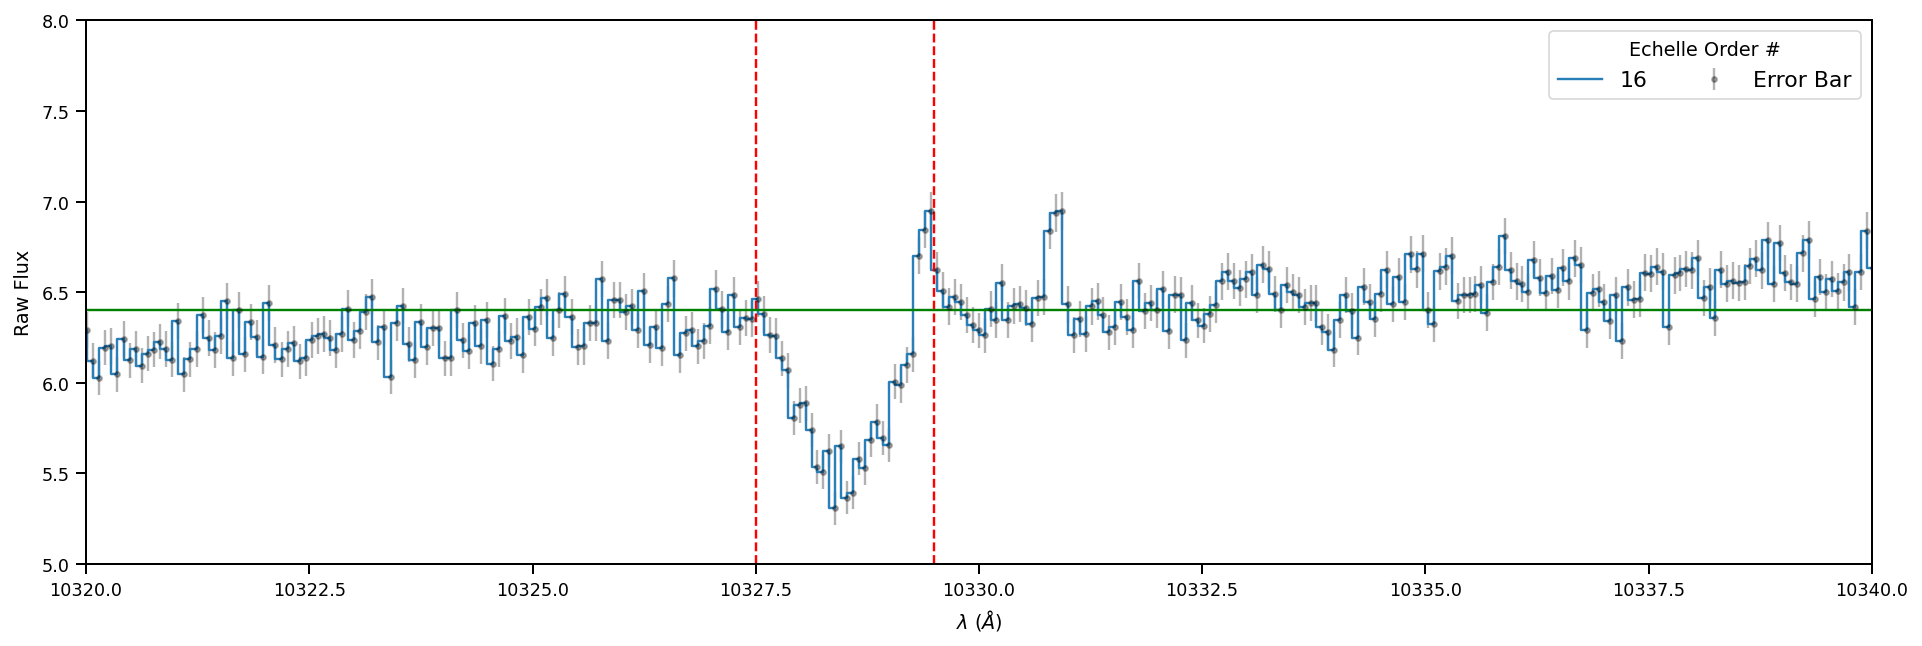

In [6]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(5,8)
plt.xlim(10320,10340)
wavelength1 = 10327.5
wavelength2 = 10329.5
continuum = 6.4
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

Ok, let's fit a model to this data.  The model will consist of a straight-line trend with a Gaussian subtracted from it.  It will have five parameters, the straight-line trend slope $m$ and offset $b$, and the Gaussian amplitude $A$, center wavelength $\mu$, and width $w$.  
$$f_\lambda(m, b, A, \mu, w)= m \lambda +b - A\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

Let's focus on the **sub-region** set by the above plot.

In [7]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10320) & (df['Sci Wavl'] < 10340)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [8]:
def generative_model(m, b, A, mu, w):
    """Generate the model given parameters"""
    continuum = m * (wl - 10330) + b
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum - gaussian

Let's make an initial guess.

In [27]:
m_guess, b_guess, A_guess, mu_guess, w_guess = 0.01, 6.4, 0.978, 10328.5, 0.4

In [28]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, w_guess)

(5.0, 8.0)

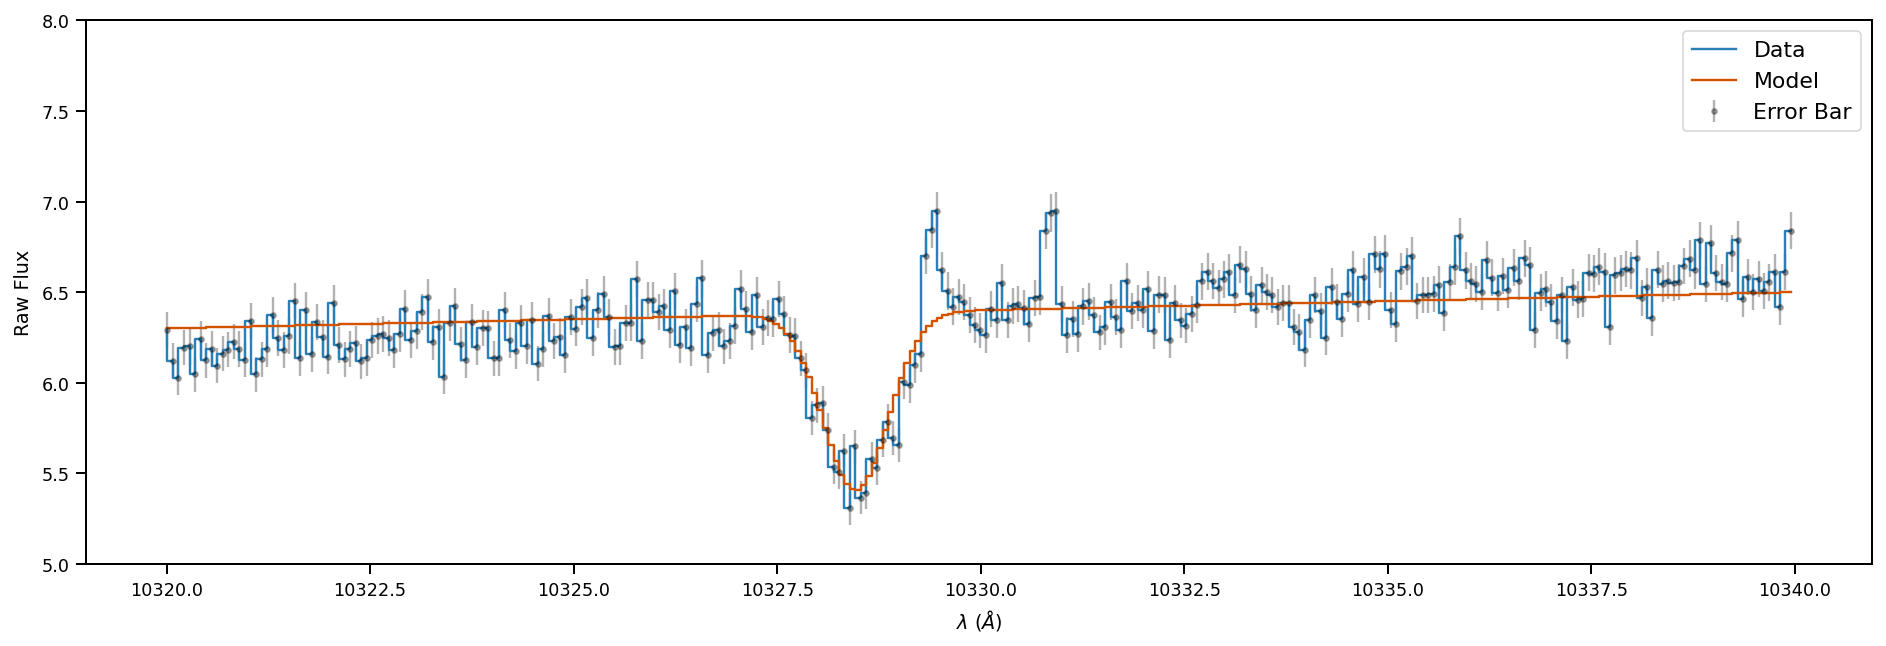

In [29]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)

The guess is *close* but not perfect-- the line center is slightly off.  That's OK!  Let's use MCMC to fine tune these parameters, and tell us the uncertainty in the parameter values.  We will use [emcee](https://emcee.readthedocs.io/en/stable/).

In [30]:
import emcee

We need to compute the log likelihood of the data, which takes in the parameters and returns a scalar "quality of fit metric".  Here we use *chi squared*, the sum of the squares of the residuals, weighted by their uncertainties.

In [31]:
def log_likelihood(theta):
    m, b, A, mu, w = theta
    model = generative_model(m, b, A, mu, w)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [32]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, w_guess])
log_likelihood(theta_guess)

-318.16768788696146

In [33]:
n_walkers = 32
n_params = 5

In [34]:
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)

In [35]:
n_steps = 5000

In [36]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 230.28it/s]


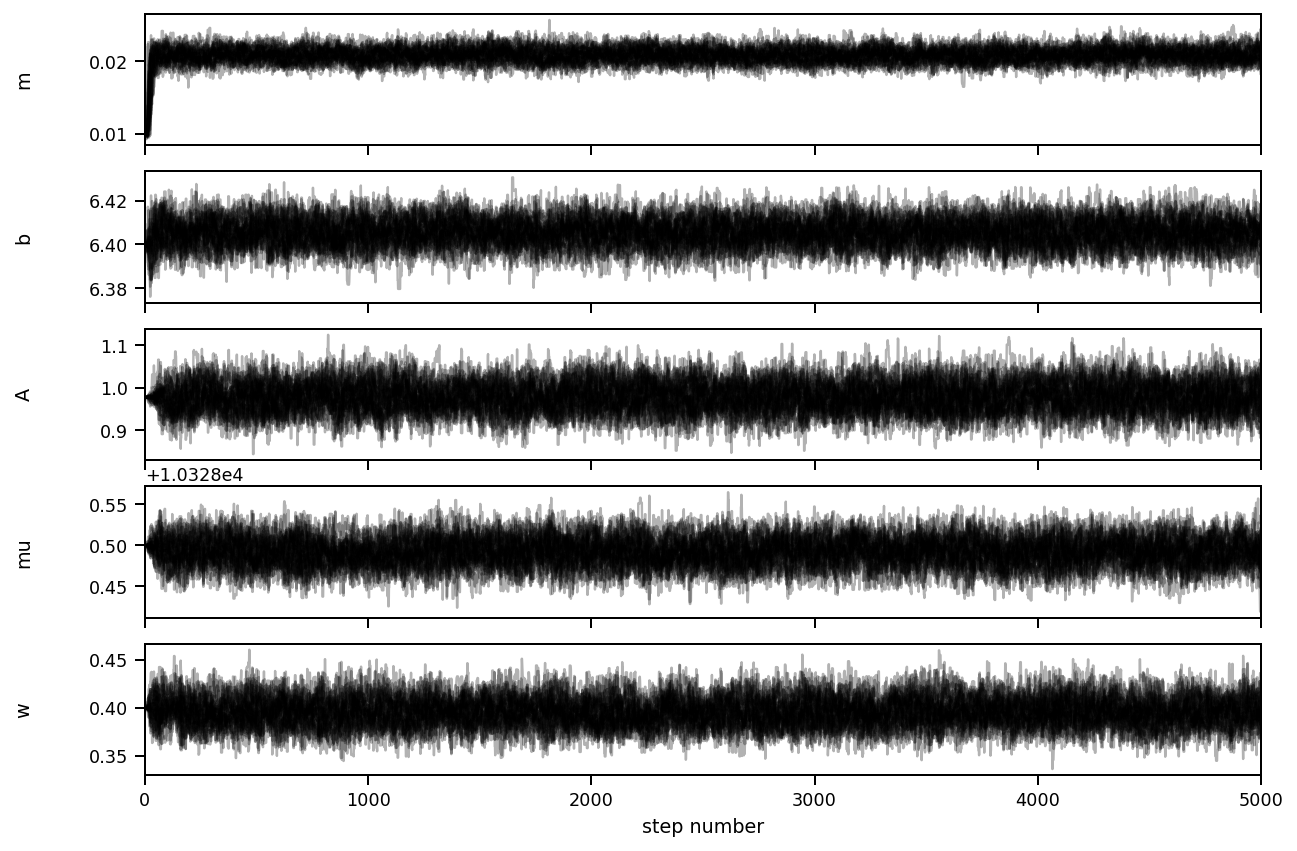

In [37]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [88]:
A_draws = samples[2000:, :, 2].reshape(-1)
b_draws = samples[2000:, :, 1].reshape(-1)
m_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 3].reshape(-1)
w_draws = samples[2000:, :, 4].reshape(-1)

0.9791676685086012
0.03452938919430559


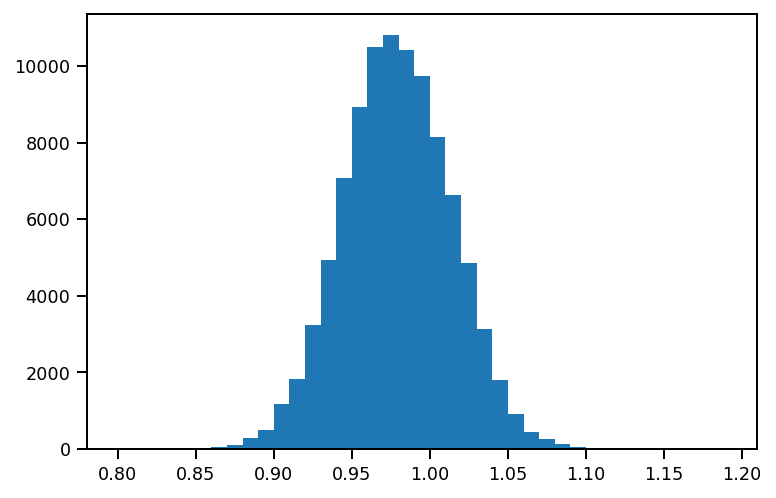

In [89]:
plt.hist(A_draws, bins = np.arange(0.8, 1.2, 0.01));
a_mean = np.mean(A_draws)
a_std = np.std(A_draws)
print(a_mean)
print(a_std)

6.405362674980213
0.006049165588198443


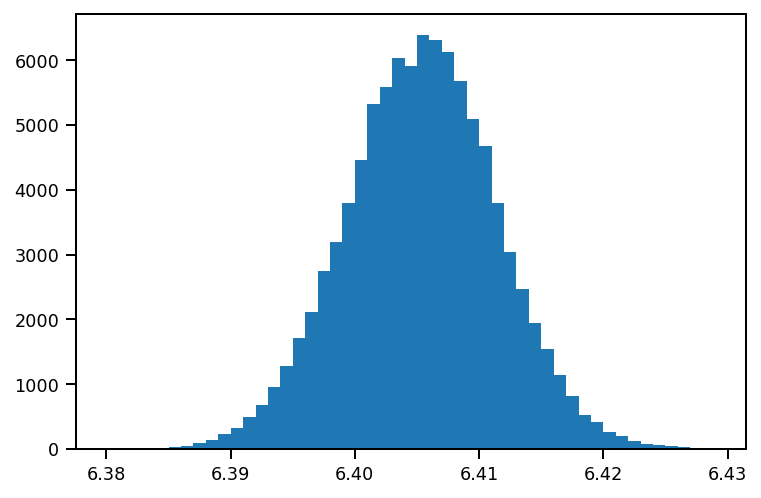

In [90]:
plt.hist(b_draws, bins = np.arange(6.38, 6.43, 0.001));
b_mean = np.mean(b_draws)
b_std = np.std(b_draws)
print(b_mean)
print(b_std)

0.02086274374273741
0.0009722266209184809


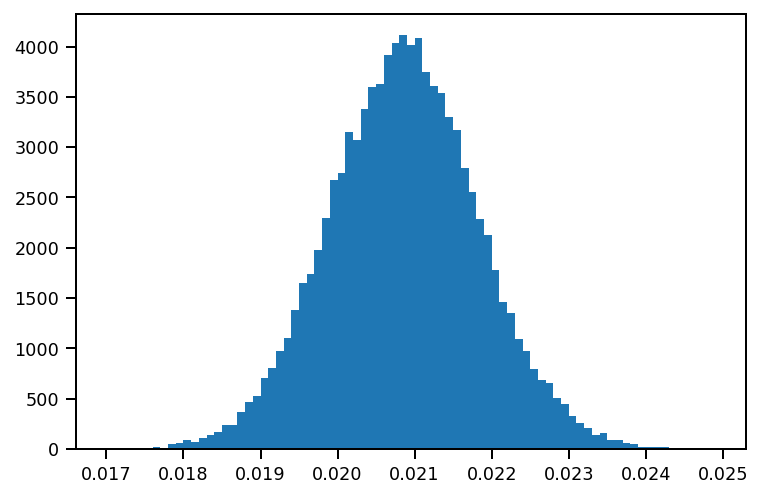

In [91]:
plt.hist(m_draws, bins = np.arange(0.017, 0.025, 0.0001));
m_mean = np.mean(m_draws)
m_std = np.std(m_draws)
print(m_mean)
print(m_std)

10328.492094194138
0.01677235337532687


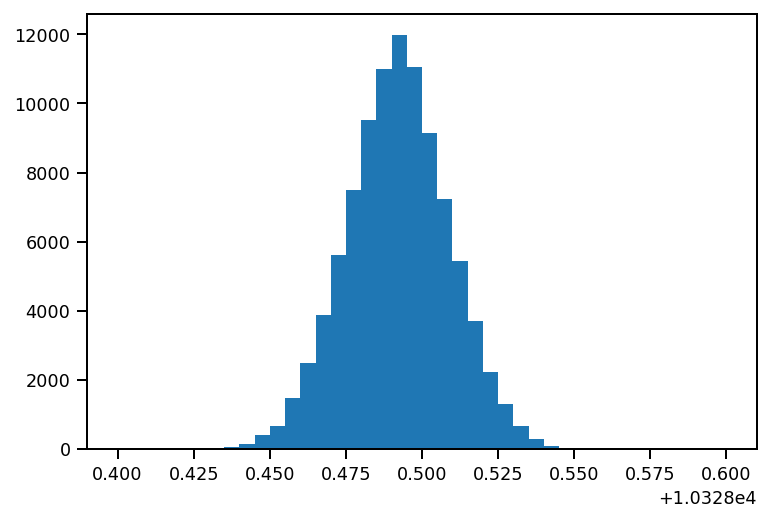

In [92]:
plt.hist(mu_draws, bins = np.arange(10328.4, 10328.6, 0.005));
mu_mean = np.mean(mu_draws)
mu_std = np.std(mu_draws)
print(mu_mean)
print(mu_std)

0.3956716650456216
0.014544809627827986


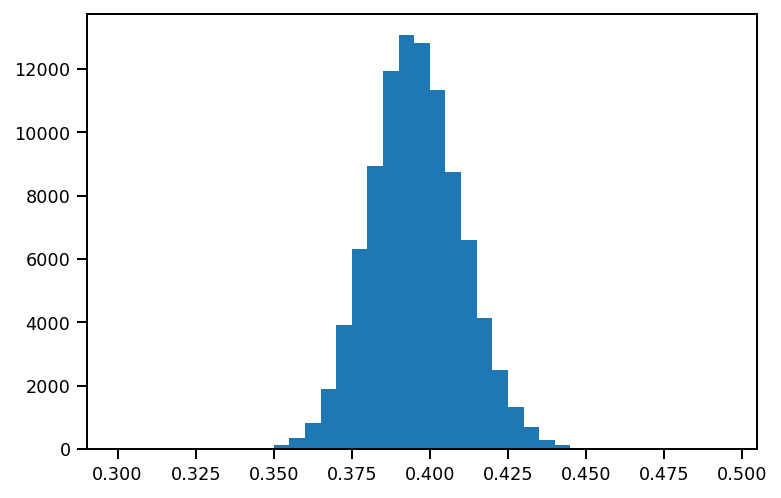

In [97]:
plt.hist(w_draws, bins = np.arange(0.3, 0.5, 0.005));
w_mean = np.mean(w_draws)
w_std = np.std(w_draws)
print(w_mean)
print(w_std)

In [100]:
means = [m_mean, b_mean, a_mean, mu_mean, w_mean]
means

[0.02086274374273741,
 6.405362674980213,
 0.9791676685086012,
 10328.492094194138,
 0.3956716650456216]

In [126]:
index = 130 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [127]:
%time df = get_goldilocks_dataframe(fn)

Wall time: 452 ms


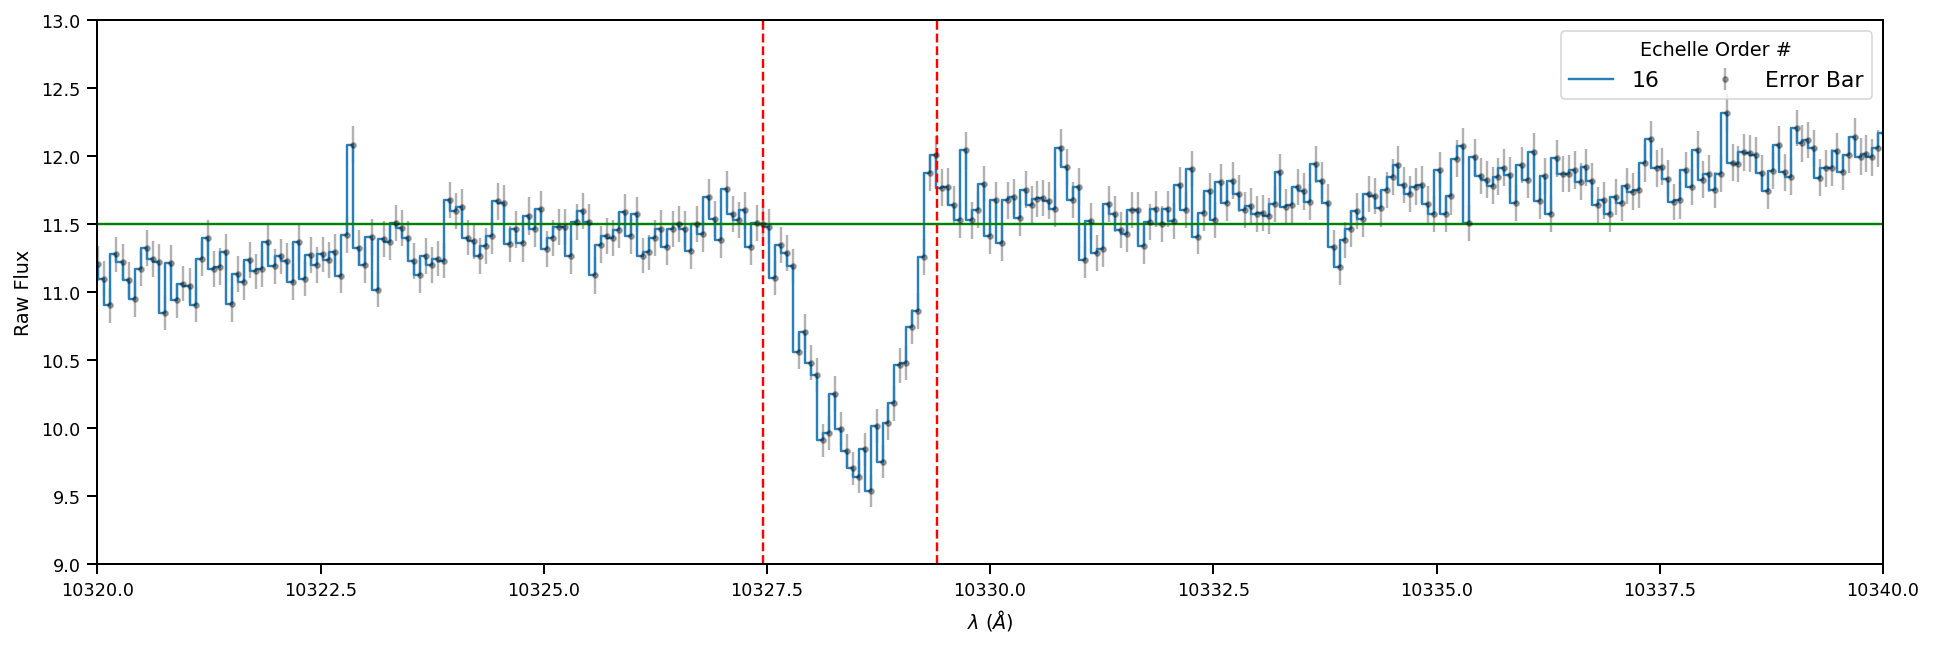

In [152]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(9,13)
plt.xlim(10320,10340)
wavelength1 = 10327.45
wavelength2 = 10329.4
continuum = 11.5
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(continuum,color = 'green')

In [148]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10320) & (df['Sci Wavl'] < 10335)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [207]:
m_guess, b_guess, A_guess, mu_guess, w_guess = 0.04, 11.5, 2, 10328.6, 0.45

In [208]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, w_guess)

(9.0, 12.5)

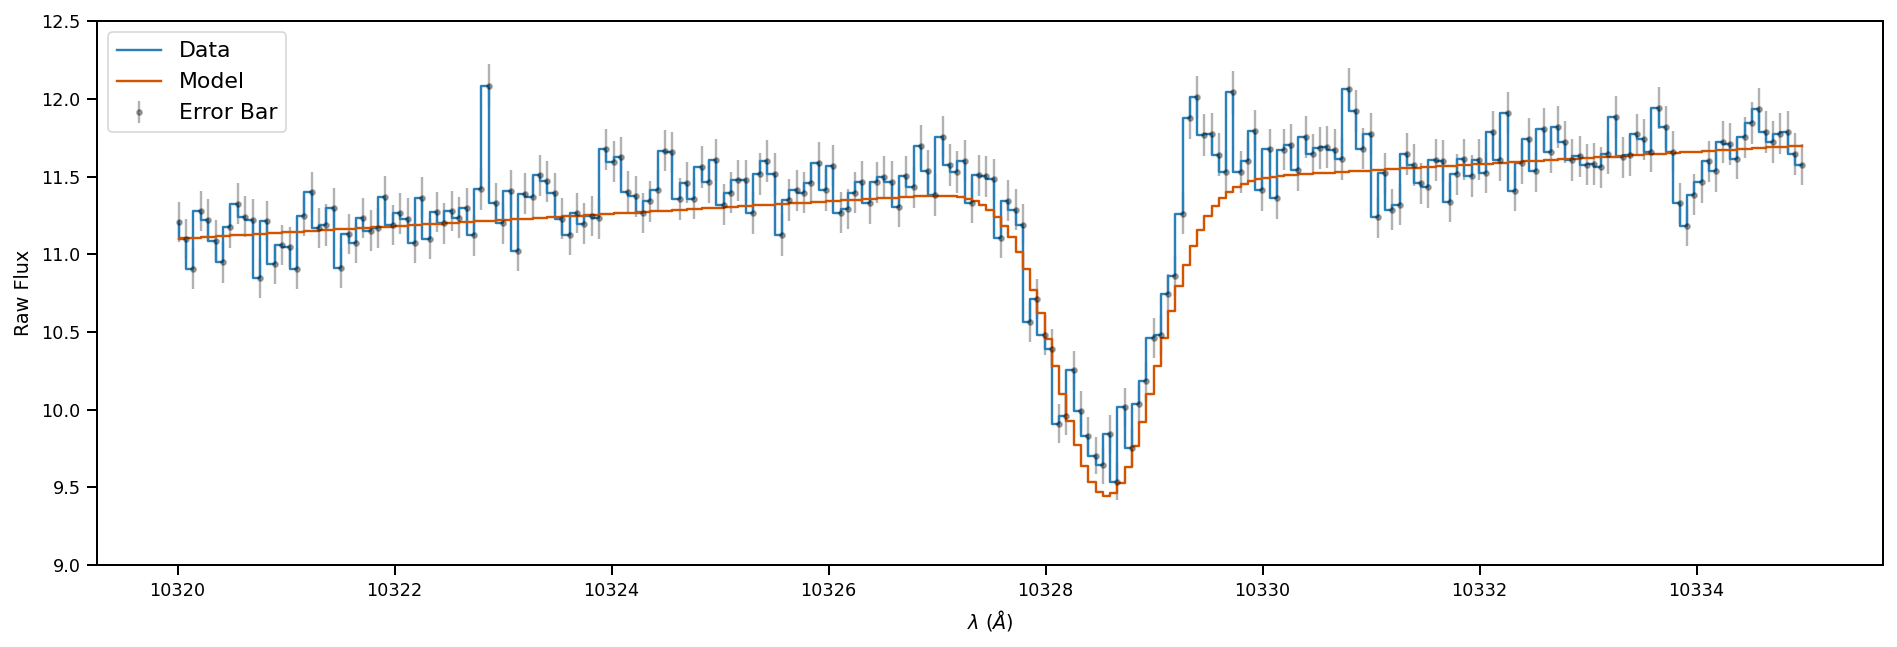

In [209]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(9,12.5)

In [213]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, w_guess])
log_likelihood(theta_guess)

-309.76403772114605

In [214]:
theta_guess

array([4.00000e-02, 1.15000e+01, 2.00000e+00, 1.03286e+04, 4.50000e-01])

In [211]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 235.81it/s]


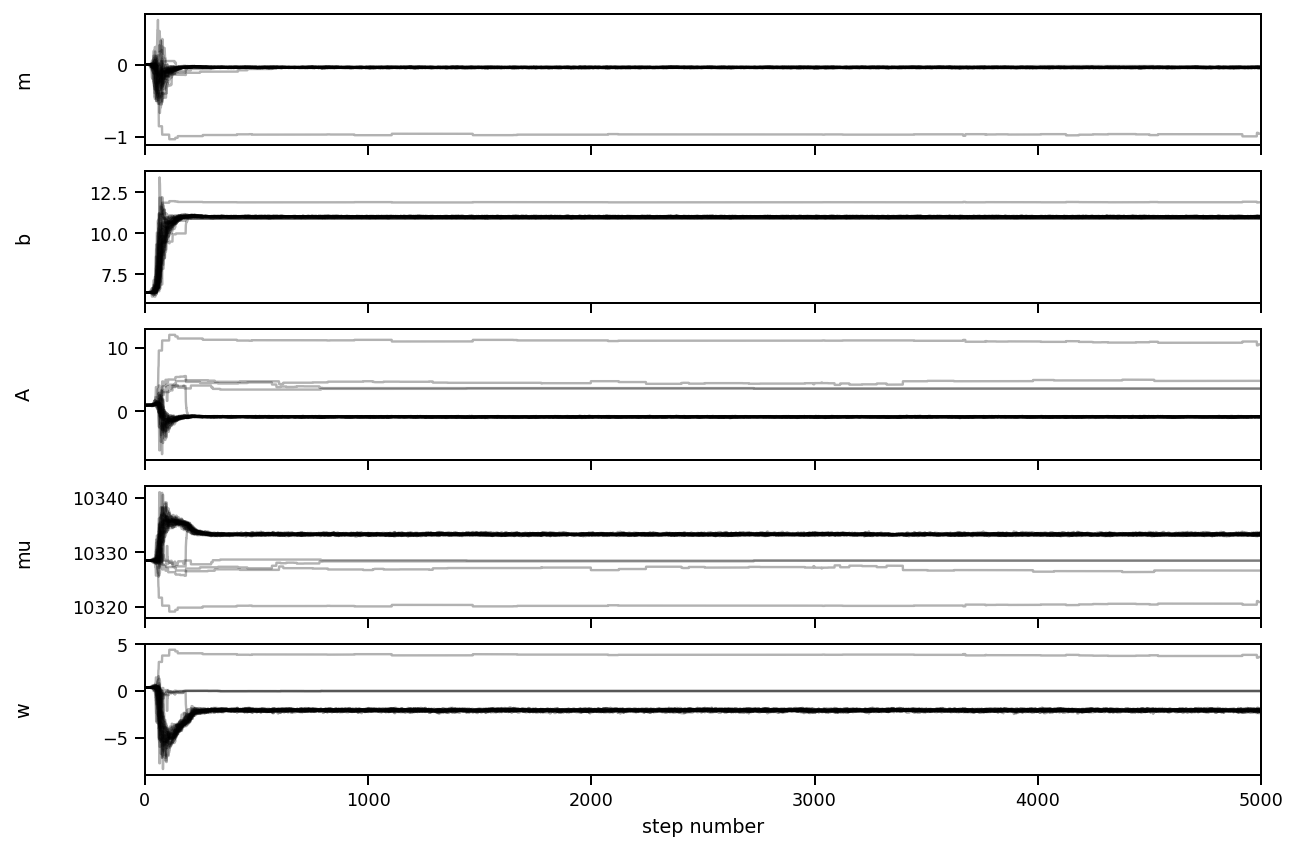

In [212]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");